#ANMNCPOP_Real_Data_Standardization
Welcome to the example for real data standardization in causal discovery!

# Input Data Form:
-------------------------------------------------------
The data can be any format that is supported by the Real_Data_Standardization() function, currently including tar.gz, csv and tsv.

**Two Dimensions Causality Data:**
* **tar.gz file**

Archiving and compressing causality files and folders as a tar.gz file.

* **csv files**

Raw data and casaul matrix are saved in separate csv files.

**Multiple Features Time Series:**
* **tsv files**

Single sample trajectory with multiple features Time Series as shape of (F features, T timeSets) - incluing S smples, i.e. S number of .tsv files

# Standardization process:
-------------------------------------------------------
* Causality Data stored as NumPy array x and y under a npz file.
* For multiple features time series data, all time series are reorganized as a (Feature_num, Sample_num, Time_sets) three-dims array for applying ANM-NCPOP.

# Output Data Form
-------------------------------------------------------
For further analysis, all useful infomation is extracted and saved as **npz file** storing causality Data as NumPy array x and y.

* **x**

An array saves F features and S smples.

Or an array saves F features, S smples and T timesets Time Series.

* **y**

A causal matrix is saved as shape of (F features, F features)

Learned underlying causal relationships between obeservations, according to expert experience or ground true causality.

# Examples
-------------------------------------------------------
In our paper, we tested Telephone, Microwave and Krebs_Cycle data in respect to testing orignal two dimensions data and multi-features time series.

* Telephone

Rawdata is saved as real_dataset_processed.csv, and
the causal_matrix is saved as true_graph.csv.

* Microwave

Rawdata is saved in Alarm.csv and causal_matrix is saved in DAG.npy.

Examples: 25V_474N_Microwave.tar.gz, 24V_439N_Microwave.tar.gz, 18V_55N_Wireless.tar.gz.

* Krebs_Cycle

Multiple features time series are saved under file Krebs_Cycle_TS. The causal_matrix is saved as true_graph.csv.

Krebs_Cycle Output:
* __x__: is an array in shape(F, S, T), where the number of row F is features_num, the number of column S is smples_num and the number of deep T is timesets.
* __y__: is a nonsymmetric square matrix.


#__Get start__


* mount drive
* set envirment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/NCPOP/Causal_Models_Learning/Test/")
# os.chdir("/content/drive/MyDrive/Colab Notebooks/NCPOP/")

Mounted at /content/drive


In [1]:
# from Data_Standardization import*
from pickle import TRUE
import os
import re
import numpy as np
import pandas as pd
import tarfile
from itertools import combinations
import urllib
import hashlib
from urllib.error import URLError
USER_AGENT = "gcastle/dataset"

def _check_exist(root, filename, files):
    path_exist = os.path.join(root, filename.split('.')[0])
    processed_folder_exists = os.path.exists(path_exist)
    if not processed_folder_exists:
        return False

    return all(
        _check_integrity(os.path.join(path_exist, file)) for file in files
    )

def _read_data(root, filename, files):
    path_exist = os.path.join(root, filename.split('.')[0])

    result = []
    for file in files:
        if file.split('.')[-1] == 'csv':
            file_path = os.path.join(path_exist, file)
            result.append(pd.read_csv(file_path))
        elif file.split('.')[-1] == 'npy':
            file_path = os.path.join(path_exist, file)
            result.append(np.load(file_path))

    if len(result) == 2:
        result.append(None)

    return result

def _check_integrity(fpath, md5=None):
    if not os.path.isfile(fpath):
        return False
    if md5 is None:
        return True

    md5f = hashlib.md5()
    with open(fpath, 'rb') as f:
        md5f.update(f.read())

    return md5 == md5f.hexdigest()


def _download(root, url, filename, md5):
    """Download the datasets if it doesn't exist already."""

    os.makedirs(root, exist_ok=True)

    # download files
    for mirror in url:
        filepath = "{}{}".format(mirror, filename)
        savegz = os.path.join(root, filename)
        try:
            print("Downloading {}".format(filepath))
            response = urllib.request.urlopen( \
                urllib.request.Request( \
                    filepath, headers={"User-Agent": USER_AGENT}))
            with open(savegz, "wb") as fh:
                fh.write(response.read())

            tar = tarfile.open(savegz)
            names = tar.getnames()
            for name in names:
                tar.extract(name, path=root)
            tar.close()
        except URLError as error:
            print("Failed to download (trying next):\n{}".format(error))
            continue
        break
    else:
        raise RuntimeError("Error downloading {}".format(filename))

    # check integrity of downloaded file
    if not _check_integrity(savegz, md5):
        raise RuntimeError("File not found or corrupted.")

def load_dataset(name='IID_Test', root=None, download=False):
    """
    A function for loading some well-known datasets.

    Parameters
    ----------
    name: class, default='IID_Test'
        Dataset name, independent and identically distributed (IID),
        Topological Hawkes Process (THP) and real datasets.
    root: str
        Root directory in which the dataset will be saved.
    download: bool
        If true, downloads the dataset from the internet and
        puts it in root directory. If dataset is already downloaded, it is not
        downloaded again.

    Return
    ------
    out: tuple
        true_graph_matrix: numpy.matrix
            adjacency matrix for the target causal graph.
        topology_matrix: numpy.matrix
            adjacency matrix for the topology.
        data: pandas.core.frame.DataFrame
            standard trainning dataset.
    """

    if name not in DataSetRegistry.meta.keys():
        raise ValueError('The dataset {} has not been registered, you can use'
                         ' ''castle.datasets.__builtin_dataset__'' to get registered '
                         'dataset list'.format(name))
    loader = DataSetRegistry.meta.get(name)()
    loader.load(root, download)
    return loader.data, loader.true_graph_matrix, loader.topology_matrix


class BuiltinDataSet(object):

    def __init__(self):
        self._data = None
        self._true_graph_matrix = None
        self._topology_matrix = None

    def load(self, *args, **kwargs):
        raise NotImplementedError

    @property
    def data(self):
        return self._data

    @property
    def true_graph_matrix(self):
        return self._true_graph_matrix

    @property
    def topology_matrix(self):
        return self._topology_matrix

class RealDataSet(BuiltinDataSet):

    def __init__(self):
        super().__init__()
        self.url = None
        self.tar_file = None
        self.md5 = None
        self.file_list = None

    def load(self, root=None, download=False):

        if root is None:
            root = './'

        if _check_exist(root, self.tar_file, self.file_list):
            self._data, self._true_graph_matrix, self._topology_matrix = \
                _read_data(root, self.tar_file, self.file_list)
            return

        if download:
            _download(root, self.url, self.tar_file, self.md5)

        if not _check_exist(root, self.tar_file, self.file_list):
            raise RuntimeError('Dataset not found.' +
                               ' You can use download=True to download it.')

        self._data, self._true_graph_matrix, self._topology_matrix = \
            _read_data(root, self.tar_file, self.file_list)


class V18_N55_Wireless(RealDataSet):
    """
    A function for loading the real dataset: V18_N55_Wireless
    url: https://raw.githubusercontent.com/gcastle-hub/dataset/master/alarm/18V_55N_Wireless.tar.gz
    """

    def __init__(self):
        super().__init__()
        self.url = ['https://raw.githubusercontent.com/gcastle-hub/dataset/master/alarm/']
        self.tar_file = "18V_55N_Wireless.tar.gz"
        self.md5 = "36ee135b86c8dbe09668d9284c23575b"
        self.file_list = ['Alarm.csv', 'DAG.npy']


class V24_N439_Microwave(RealDataSet):
    """
    A function for loading the real dataset: V24_N439_Microwave
    url: https://raw.githubusercontent.com/gcastle-hub/dataset/master/alarm/24V_439N_Microwave.tar.gz
    """

    def __init__(self):
        super().__init__()
        self.url = ['https://raw.githubusercontent.com/gcastle-hub/dataset/master/alarm/']
        self.tar_file = "24V_439N_Microwave.tar.gz"
        self.md5 = "b4c8b32d34c04a86aa93c7259f7d086c"
        self.file_list = ['Alarm.csv', 'DAG.npy', 'Topology.npy']


class V25_N474_Microwave(RealDataSet):
    """
    A function for loading the real dataset: V25_N474_Microwave
    url: https://raw.githubusercontent.com/gcastle-hub/dataset/master/alarm/25V_474N_Microwave.tar.gz
    """

    def __init__(self):
        super().__init__()
        self.url = ['https://raw.githubusercontent.com/gcastle-hub/dataset/master/alarm/']
        self.tar_file = "25V_474N_Microwave.tar.gz"
        self.md5 = "51f43ed622d4b44ef6daf8fabf81e162"
        self.file_list = ['Alarm.csv', 'DAG.npy', 'Topology.npy']


class DataSetRegistry(object):
    '''
    A class for resgistering the datasets, in which each dataset
    can be loaded by 'load_dataset' api.
    '''

    meta = {'V18_N55_Wireless': V18_N55_Wireless,
            'V24_N439_Microwave': V24_N439_Microwave,
            'V25_N474_Microwave': V25_N474_Microwave}



class Real_Data_Standardization(object):
    '''
    A class for preparing data to simulate random (causal) DAG.

    Parameters
    ------------------------------------------------------------------------------------------------
    File_PATH: str
               Read file path
    File_NAME: str
               Read data name

    Returns
    ------------------------------------------------------------------------------------------------
    Input data: npz
            Raw_data：[d, n, T] sample time series
            true_dag: true_causal_matrix
    File_PATH_Datasets:
            Route of saving test data

    Examples
    -------------------------------------------------------------------------------------------------
    >>> File_PATH = "../Test/Examples/Test_data/"
    >>> file_name = 'Telephone'
    >>> dt = Real_Data_Standardization(File_PATH, file_name)
    >>> dt.standardize_data()

    >>> File_PATH = "../Test/Datasets/Synthetic datasets/Krebs_Cycle/"
    >>> file_name = 'Krebs_Cycle'
    >>> dt = Real_Data_Standardization(File_PATH, file_name)
    >>> dt.standardize_data()

    >>> File_PATH = "../Test/Datasets/Real_data/Microwave/"
    >>> file_name = 'V24_N439_Microwave'
    >>> dt = Real_Data_Standardization(File_PATH, file_name)
    >>> dt.standardize_data()
    '''

    def __init__(self, File_PATH='Kreb_Cycles/', filename='Krebs_Cycle'):
        self.File_PATH = File_PATH
        self.filename = filename

    def standardize_data(self):
        ################################################  Create Ground Tier Folders #############################################
        self.File_PATH_Base = self.File_PATH +'Result_'+ self.filename +'/'

        ################################################  Create First Tier Folders #############################################
        self.File_PATH_Datasets = self.File_PATH_Base + 'Datasets_'+ self.filename +'/'
        if not os.path.exists(self.File_PATH_Datasets):
            os.makedirs(self.File_PATH_Datasets)
        print('ANM-NCPOP INFO: Created Datasets' + ' File!')

        Raw_data = Real_Data_Standardization.Produce_Rawdata(self)[0]
        true_dag = Real_Data_Standardization.Produce_Rawdata(self)[1]

        # save numpy to npz file
        nn = len(true_dag)
        ne = np.count_nonzero(true_dag)
        data_name = self.filename  +'_'+str(nn)+'Nodes_'+str(ne)+'Edges_TS'
        if self.filename in ['IID_Test','THP_Test','V18_N55_Wireless', 'V24_N439_Microwave', 'V25_N474_Microwave']:
            topology_matrix_devices = Real_Data_Standardization.Produce_Rawdata(self)[2]
            np.savez(self.File_PATH_Datasets + data_name +'.npz', x=Raw_data , y=true_dag , z=topology_matrix_devices)
        else:
            np.savez(self.File_PATH_Datasets + data_name +'.npz', x=Raw_data , y=true_dag)
        print('ANM-NCPOP INFO: Finished '+ data_name+' dataset standardization!')

    @staticmethod
    def Produce_Rawdata(self):

        def readable_File(FilePATH):
            read_Dir=os.listdir(FilePATH)
            count = 0
            readable_F = []
            for f in read_Dir:
                file = os.path.join(FilePATH, f)
                if os.path.isdir(file):
                    count = count+1
                else:
                    readable_F.append(f)
            return count,readable_F

        self.Read_File = readable_File(self.File_PATH)[1]

        # Website data
        if self.filename in ['IID_Test','THP_Test','V18_N55_Wireless', 'V24_N439_Microwave', 'V25_N474_Microwave']:
            Raw_data, true_dag, topology_matrix_devices  = load_dataset(self.filename, download=True)
            return Raw_data, true_dag, topology_matrix_devices

        else:
            # Check empty files under riute
            if len(self.Read_File ) == 0:
                raise ValueError('No Data Under the Current Route!')
            else:
                self.File_PATH_TS = self.File_PATH +self.filename +'_TS/'
                File_NAME = []
                File_TYPE = []
                # Delete files and list readable Files
                for i in self.Read_File:
                    File_NAME.append(re.split("\.", i)[0])
                    File_TYPE.append(re.split("\.", i)[1])

                ###################################### Deal with Two Dimensions Causality Data ###################################
                if self.filename+'.npz' in self.Read_File:
                    Test_data = np.load(self.File_PATH + self.filename+'.npz', allow_pickle=True)
                    Raw_data = Test_data['x']
                    true_dag = Test_data['y']
                    return Raw_data, true_dag

                elif self.filename+'.tar.gz' in self.Read_File:
                    # open file
                    file = tarfile.open(self.File_PATH + self.filename + '.tar.gz')
                    file_names = file.getnames()
                    # extract files
                    file.extractall(self.File_PATH)
                    file.close()
                    Raw_data = np.load(self.File_PATH+file_names[2])
                    true_dag = pd.read_csv(self.File_PATH+file_names[3])
                    return Raw_data, true_dag

                elif self.filename+'.csv' in self.Read_File:
                    Raw_data = pd.read_csv(self.File_PATH+ self.filename+'.csv', header=0, index_col=False)
                    true_dag = pd.read_csv(self.File_PATH+'true_graph.csv', header=0, index_col=0)
                    return Raw_data, true_dag

                ################################ Deal with Multi-dimensions Causality Data ###################################
                elif os.path.exists(self.File_PATH_TS):
                    read_Dir_TS=os.listdir(self.File_PATH_TS)
                    true_graph = np.load(self.File_PATH+'true_graph.npz')

                    # labels = ["FUMARATE", "GTP", "H2O", "CIS-ACONITATE", "MALATE",
                    # "OXALOACETATE", "FAD", "SUCCINYL-COA", "NAD",
                    #           "A-K-GLUTARATE", "GDP", "NADH", "CITRATE", "SUCCINATE",
                    # "ISOCITRATE", "ACETY-COA"]
                    #true_dag = pd.DataFrame(true_graph['arr_0'],  index=labels, columns=labels)
                    true_dag = pd.DataFrame(true_graph['arr_0'])

                    # print(true_dag)
                    lds = pd.read_csv(self.File_PATH_TS+ read_Dir_TS[0], delimiter='\t', index_col=0, header=None)
                    feature_name = np.array(lds.index)
                    feature_num = len(feature_name)
                    sample_num = len(read_Dir_TS)
                    T_num = lds.shape[1]
                    # if labels == feature_name:
                    Raw_data = np.zeros((feature_num, sample_num, T_num))
                    for ns in range(sample_num):
                        X = pd.read_csv(self.File_PATH_TS+ read_Dir_TS[ns], delimiter='\t', index_col=0, header=None)
                        X_trans = np.transpose(X)
                        for fn in range(feature_num):
                            Raw_data[fn, ns, :] = list(X_trans[feature_name[fn]])
                    return Raw_data, true_dag

                else:
                    raise ValueError('Unknown input data type.')


In [ ]:
__builtin_dataset__ = DataSetRegistry.meta.keys()

In [ ]:
__builtin_dataset__

dict_keys(['V18_N55_Wireless', 'V24_N439_Microwave', 'V25_N474_Microwave'])

In [ ]:
X, true_dag, topology_matrix = load_dataset(name='IID_Test')

In [ ]:
X, true_causal_matrix, topology_matrix = load_dataset('THP_Test')

In [ ]:
X, true_causal_matrix, topology_matrix  = load_dataset('V24_N439_Microwave', download=True)

In [ ]:
X.max()

alarm_id               23
device_id             438
start_timestamp    518368
end_timestamp      518368
dtype: int64

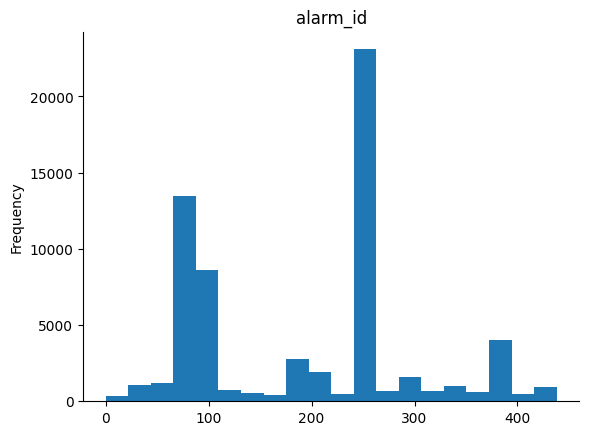

In [ ]:
from matplotlib import pyplot as plt
X['device_id'].plot(kind='hist', bins=20, title='alarm_id')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
true_causal_matrix.shape

(24, 24)

In [ ]:
topology_matrix.shape

(439, 439)

## __Test 1: Telephone_55Nodes_587Edges__

In [ ]:
File_PATH = "../Test/Examples/Test_data/"
file_name = 'Telephone'
dt = Real_Data_Standardization(File_PATH, file_name)
dt.standardize_data()

ANM-NCPOP INFO: Created Datasets File!
ANM-NCPOP INFO: Finished Telephone_55Nodes_587Edges_TS dataset standardization!


## __Test 2: Krebs_Cycle_16Nodes_43Edge__

In [ ]:
# Krebs_Cycle
File_PATH = "../Test/Datasets/Synthetic datasets/Krebs_Cycle/"
file_name = 'Krebs_Cycle'
dt = Real_Data_Standardization(File_PATH, file_name)
dt.standardize_data()

ANM-NCPOP INFO: Created Datasets File!
ANM-NCPOP INFO: Finished Krebs_Cycle_16Nodes_43Edges_TS dataset standardization!


## __Test 3: Microwave_25Alarm_474Devices__

In [ ]:
File_PATH = "../Test/Datasets/Real_data/Microwave/"
file_name = 'V24_N439_Microwave'
dt = Real_Data_Standardization(File_PATH, file_name)
dt.standardize_data()


ANM-NCPOP INFO: Created Datasets File!
ANM-NCPOP INFO: Finished V24_N439_Microwave_24Nodes_137Edges_TS dataset standardization!


# __Step-by-Step__

##__Step 1: Standardized Data class__

In [ ]:
# from Data_Standardization import*
from pickle import TRUE
import os
import re
import numpy as np
import pandas as pd
import tarfile
from itertools import combinations

class Real_Data_Standardization(object):
    '''
    A class for preparing data to simulate random (causal) DAG.

    Parameters
    ----------
    File_PATH: str
        Read file path
    File_NAME: str
        Read data name
    '''

    def __init__(self, File_PATH, Data_NAME):
        self.File_PATH = File_PATH
        self.Data_NAME = Data_NAME

    def Produce_Rawdata(self):

        def readable_File(FilePATH):
            read_Dir=os.listdir(FilePATH)
            count = 0
            readable_F = []
            for f in read_Dir:
                file = os.path.join(FilePATH, f)
                if os.path.isdir(file):
                    count = count+1
                else:
                    readable_F.append(f)
            return count,readable_F

        self.Read_File = readable_File(self.File_PATH)[1]
        self.TS_path = self.File_PATH + self.Data_NAME + '_TS/'

        # Check empty files under riute
        if len(self.File_PATH) == 0:
            print('INFO: No Data Under the Current Route!')
        else:
            File_NAME = []
            File_TYPE = []

            # Delete files and list readable Files
            for i in self.Read_File:
                File_NAME.append(re.split("\.", i)[0])
                File_TYPE.append(re.split("\.", i)[1])

            ###################################### Deal with Two Dimensions Causality Data ###################################
            '''if self.Data_NAME+'.npz' in self.Read_File:
                Tests_data = np.load(self.File_PATH + self.Data_NAME+'.npz', allow_pickle=True)
                Raw_data = Tests_data['x']
                true_dag = Tests_data['y']
                print('INFO: Check for '+self.Data_NAME +'.npz'+ '!')'''

            if self.Data_NAME+'.tar.gz' in self.Read_File:
                # open file
                file = tarfile.open(self.File_PATH + self.Data_NAME + '.tar.gz')

                # print file names
                file_names = file.getnames()
                print(file_names)

                # extract files
                file.extractall(self.File_PATH)

                # close file
                file.close()

                Raw_data = np.load(self.File_PATH+file_names[2])
                true_dag = pd.read_csv(self.File_PATH+file_names[3])

                # save numpy to npz file
                np.savez(self.Data_NAME+'.npz', x=Raw_data , y=true_dag)
                print('INFO: Check for '+self.Data_NAME +'.npz'+ '!')

            elif self.Data_NAME+'.csv' in self.Read_File:
                Raw_data = pd.read_csv(self.File_PATH+ self.Data_NAME+'.csv', header=0, index_col=False)
                true_dag = pd.read_csv(self.File_PATH+'true_graph.csv', header=0, index_col=0)

                # save numpy to npz file
                np.savez(self.Data_NAME+'.npz', x=Raw_data , y=true_dag)
                print('INFO: Check for '+self.Data_NAME +'.npz'+ '!')

            ################################ Deal with Multi-dimensions Causality Data ###################################
            elif os.path.exists(self.TS_path):
                read_Dir_TS=os.listdir(self.TS_path)
                true_graph = np.load(self.File_PATH+'true_graph.npz')

                labels = ["FUMARATE", "GTP", "H2O", "CIS-ACONITATE", "MALATE",
                "OXALOACETATE", "FAD", "SUCCINYL-COA", "NAD",
                          "A-K-GLUTARATE", "GDP", "NADH", "CITRATE", "SUCCINATE",
                "ISOCITRATE", "ACETY-COA"]
                true_dag = pd.DataFrame(true_graph['arr_0'],  index=labels, columns=labels)
                # print(true_dag)
                lds = pd.read_csv(self.TS_path+ read_Dir_TS[0], delimiter='\t', index_col=0, header=None)
                feature_name = np.array(lds.index)
                # lds_trans = np.transpose(lds)
                # feature_name = lds_trans.columns
                feature_num = len(feature_name)
                sample_num = len(read_Dir_TS)
                T_num = lds.shape[1]
                # if labels == feature_name:
                df = np.zeros((feature_num, sample_num, T_num))
                Raw_data = np.zeros((feature_num, sample_num *T_num))
                for ns in range(sample_num):
                    X = pd.read_csv(self.TS_path+ read_Dir_TS[ns], delimiter='\t', index_col=0, header=None)
                    X_trans = np.transpose(X)
                    for fn in range(feature_num):
                        df[fn, ns, :] = list(X_trans[feature_name[fn]])
                for fn in range(feature_num):
                    Raw_data[fn, :] = list(df[fn, :, :].reshape(-1))

                non_zero_count = np.count_nonzero(true_dag)

                # save numpy to npz file
                sname = self.Data_NAME + '_'+str(feature_num)+'_'+str(non_zero_count)+'_TS_1'
                np.savez(sname+'.npz', x=Raw_data , y=true_dag)
                print('INFO: Check for '+sname + '!')

            else:
                print('INFO: Wrong DataType!')

            '''
            ################################ Deal with Multi-dimensions Causality Data ###################################
            elif os.path.exists(self.TS_path):
                read_Dir_TS=os.listdir(self.TS_path)
                # true_dag = pd.read_csv(self.File_PATH+'true_graph.csv', header=0, index_col=0)
                true_graph = np.load(self.File_PATH+'true_graph.npz')

                labels = ["FUMARATE", "GTP", "H2O", "CIS-ACONITATE", "MALATE",
                "OXALOACETATE", "FAD", "SUCCINYL-COA", "NAD",
                          "A-K-GLUTARATE", "GDP", "NADH", "CITRATE", "SUCCINATE",
                "ISOCITRATE", "ACETY-COA"]
                true_dag = pd.DataFrame(true_graph['arr_0'],  index=labels, columns=labels)
                # print(true_dag)
                lds = pd.read_csv(self.TS_path+ read_Dir_TS[0], delimiter='\t', index_col=0, header=None)
                feature_name = np.array(lds.index)
                # lds_trans = np.transpose(lds)
                # feature_name = lds_trans.columns
                feature_num = len(feature_name)
                sample_num = len(read_Dir_TS)
                T_num = lds.shape[1]
                # if labels == feature_name:
                Raw_data = np.zeros((feature_num, sample_num, T_num))
                for ns in range(sample_num):
                    X = pd.read_csv(self.TS_path+ read_Dir_TS[ns], delimiter='\t', index_col=0, header=None)
                    X_trans = np.transpose(X)
                    for fn in range(feature_num):
                        Raw_data[fn, ns, :] = list(X_trans[feature_name[fn]])
                non_zero_count = np.count_nonzero(true_dag)

                # save numpy to npz file
                sname = self.Data_NAME + '_'+str(feature_num)+'_'+str(non_zero_count)+'_TS'
                np.savez(sname+'.npz', x=Raw_data , y=true_dag)
                print('INFO: Check for '+sname + '!')'''


##__Step 2: Test__

In [ ]:
if __name__ == "__main__":
    ############################################################################################################
    ############################################ SETTING File_PATH and file_name ###############################
    ############################################################################################################
    # Krebs_Cycle
    File_PATH = "/content/drive/MyDrive/Colab Notebooks/NCPOP/Causal_Models_Learning/Test/Datasets/Synthetic datasets/Krebs_Cycle/"
    file_name = 'Krebs_Cycle'

    '''
    # Microwave
    File_PATH = "/content/drive/MyDrive/Colab Notebooks/NCPOP/Causal_Models_Learning/Test/Datasets/Real_data/Microwave/"
    file_name = '25V_474N_Microwave'

    # Telephone
    File_PATH = "/content/drive/MyDrive/Colab Notebooks/NCPOP/Causal_Models_Learning/Test/Datasets/Real_data/Telephone/"
    file_name = 'Telephone'

    '''

    dt = Real_Data_Standardization(File_PATH, file_name)
    dt.Produce_Rawdata()



INFO: Check for Krebs_Cycle_16_43_TS_1!


In [ ]:
data = np.load('Krebs_Cycle_16_43_TS_1.npz')
Raw_data = data['x']
true_dag = data['y']
print(Raw_data.shape, true_dag.shape)

(16, 60000) (16, 16)


# Backup

In [ ]:
df = np.zeros((4, 2*3))
df.shape

(4, 6)

In [ ]:
df = np.zeros((4, 2,3))
df.shape

(4, 2, 3)

In [ ]:
# from Data_Standardization import*
from pickle import TRUE
import os
import re
import numpy as np
import pandas as pd
import tarfile
from itertools import combinations

class Real_Data_Standardization(object):
    '''
    A class for preparing data to simulate random (causal) DAG.

    Parameters
    ----------
    File_PATH: str
        Save file path
    File_NAME: str
        Read data name
    '''

    def __init__(self, File_PATH, Data_NAME):
        self.File_PATH = File_PATH
        self.Data_NAME = Data_NAME

    def Produce_Rawdata(self):

        def readable_File(FilePATH):
            read_Dir=os.listdir(FilePATH)
            count = 0
            readable_F = []
            for f in read_Dir:
                file = os.path.join(FilePATH, f)
                if os.path.isdir(file):
                    count = count+1
                else:
                    readable_F.append(f)
            return count,readable_F

        self.Read_File = readable_File(self.File_PATH)[1]
        self.TS_path = self.File_PATH + self.Data_NAME + '_TS/'

        # Check empty files under riute
        if len(self.File_PATH) == 0:
            print('INFO: No Data Under the Current Route!')
        else:
            File_NAME = []
            File_TYPE = []

            # Delete files and list readable Files
            for i in self.Read_File:
                File_NAME.append(re.split("\.", i)[0])
                File_TYPE.append(re.split("\.", i)[1])

            ###################################### Deal with Two Dimensions Causality Data ###################################
            if self.Data_NAME+'.npz' in self.Read_File:
                Tests_data = np.load(self.File_PATH + self.Data_NAME+'.npz', allow_pickle=True)
                Raw_data = Tests_data['x']
                true_dag = Tests_data['y']
                print('INFO: Check for '+self.Data_NAME +'.npz'+ '!')

            elif self.Data_NAME+'.tar.gz' in self.Read_File:
                # open file
                file = tarfile.open(self.File_PATH + self.Data_NAME + '.tar.gz')

                # print file names
                file_names = file.getnames()
                print(file_names)

                # extract files
                file.extractall(self.File_PATH)

                # close file
                file.close()

                Raw_data = pd.read_csv(self.File_PATH+file_names[1])
                true_dag = np.load(self.File_PATH+file_names[2])

                # save numpy to npz file
                np.savez(self.File_PATH + self.Data_NAME+'.npz', x=Raw_data , y=true_dag)
                print('INFO: Check for '+self.Data_NAME +'.npz'+ '!')

            elif self.Data_NAME+'.csv' in self.Read_File:
                Raw_data = pd.read_csv(self.File_PATH+ self.Data_NAME+'.csv', header=0, index_col=0)
                true_dag = pd.read_csv(self.File_PATH+'true_graph.csv', header=0, index_col=0)

                # save numpy to npz file
                np.savez(self.File_PATH + self.Data_NAME+'.npz', x=Raw_data , y=true_dag)
                print('INFO: Check for '+self.Data_NAME +'.npz'+ '!')

            ################################ Deal with Multi-dimensions Causality Data ###################################
            elif os.path.exists(self.TS_path):
                read_Dir_TS=os.listdir(self.TS_path)
                Timeseries_List_path = self.File_PATH+'series_list.csv'
                Read_Timeseries = pd.read_csv(Timeseries_List_path)
                # print(len(Read_Timeseries), len(read_Dir_TS))
                if len(Read_Timeseries) >= len(read_Dir_TS):
                    print('INFO: Start Analyzing '+ self.Data_NAME + ' Time Series File!')
                    TS_List = read_Dir_TS
                else:
                    print('INFO: Start Analyzing '+ self.Data_NAME + ' Time Series List!')
                    TS_List = Read_Timeseries['Series_num']
                lds = pd.read_csv(self.TS_path+ TS_List[0], delimiter='\t', index_col=0, header=None)
                # print(lds)
                n = len(TS_List)
                T = lds.shape[1]
                # d = lds.shape[0]
                # print(d, T, n)
                df = np.transpose(lds)
                feature_name = df.columns
                d = len(feature_name)
                Raw_data = np.zeros((d, n, T))
                for ns in range(n):
                    X = pd.read_csv(self.TS_path+ TS_List[ns], delimiter='\t', index_col=0, header=None)
                    df = np.transpose(X)
                    feature_name = df.columns
                    for fn in range(d):
                        Raw_data[fn, ns, :] = list(df[feature_name[fn]])
                # print(Raw_data.shape)
                # save numpy to npz file
                matrix = np.zeros((d, d))
                np.fill_diagonal(matrix, 0)
                np.fill_diagonal(matrix[:, 1:], 1)
                np.savez(self.File_PATH + self.Data_NAME+'.npz', x=Raw_data , y=matrix)
                print('INFO: Check for '+self.Data_NAME +'.npz'+ '!')

            else:
                print('INFO: Wrong DataType!')


In [ ]:
import pandas as pd
File_PATH = '/content/drive/MyDrive/Colab Notebooks/Causality_NotesTest/Test_Causality_Datasets/Telephone/'
Raw_data_path = File_PATH+'real_dataset_processed.csv'
Raw_dag_path = File_PATH+'true_graph.csv'

x = pd.read_csv(Raw_data_path, header=0)
y = pd.read_csv(Raw_dag_path, header=0, index_col=0)

np.savez('/content/drive/MyDrive/Colab Notebooks/Causality_NotesTest/Test_Causality_Datasets/Real_data/Telephone.npz', x=x, y=y)

##Debug class

In [ ]:
import pandas as pd
import numpy as np
import tarfile
import os
import re
import sys
from itertools import combinations
from pickle import TRUE

File_PATH = "/content/drive/MyDrive/Colab Notebooks/NCPOP-Colab Notebooks/Test_Causality_Datasets/Real_data/Krebs_Cycle/"
os.chdir(File_PATH)
read_Dir=os.listdir(File_PATH)
Data_NAME = 'Krebs_Cycle'
Readable_File = readable_File(File_PATH)[1]
num_readable_File = len(read_Dir) - readable_File(File_PATH)[0]
TS_path = File_PATH+Data_NAME+'_TS/'

def readable_File(path):
    read_Dir=os.listdir(path)
    count = 0
    readable_File = []
    for f in read_Dir:
      file = os.path.join(path, f)
      if os.path.isdir(file):
        count = count+1
      else:
        readable_File.append(f)
    return count,readable_File

read_Dir_TS=os.listdir(TS_path)
Timeseries_List_path = File_PATH+'series_list.csv'
Read_Timeseries = pd.read_csv(Timeseries_List_path)
# print(len(Read_Timeseries), len(read_Dir_TS))
if len(Read_Timeseries) >= len(read_Dir_TS):
  print('INFO: Start Analyzing '+ Data_NAME + ' Time Series File!')
  TS_List = read_Dir_TS
else:
  print('INFO: Start Analyzing '+ Data_NAME + ' Time Series List!')
  TS_List = Read_Timeseries['Series_num']


INFO: Start Analyzing Krebs_Cycle Time Series List!


##Tested

In [ ]:
from pickle import TRUE
import os
import re
import numpy as np
import pandas as pd
import tarfile
from itertools import combinations

File_PATH = "/content/drive/MyDrive/Colab Notebooks/NCPOP-Colab Notebooks/Test_Causality_Datasets/Real_data/Krebs_Cycle/"
os.chdir(File_PATH)
# os.chdir("/content/drive/MyDrive/Colab Notebooks/NCPOP-Colab Notebooks/Test_Causality_Datasets/Real_data/Krebs_Cycle/")

# self.File_PATH
read_Dir=os.listdir(File_PATH)
Data_NAME = 'real_dataset_processed'
print(File_PATH)

def readable_File(path):
    read_Dir=os.listdir(path)
    count = 0
    readable_File = []
    for f in read_Dir:
      file = os.path.join(path, f)
      if os.path.isdir(file):
        count = count+1
      else:
        readable_File.append(f)
    return count,readable_File

readable_File(File_PATH)[1]


/content/drive/MyDrive/Colab Notebooks/NCPOP-Colab Notebooks/Test_Causality_Datasets/Real_data/Krebs_Cycle/


['series_list.csv',
 'real_dataset_processed.csv',
 'true_graph.csv',
 'stock-market.txt',
 'linearGauss_6_15.npz',
 '18V_55N_Wireless.tar.gz']

In [ ]:
# File_NAME = data\\
Readable_File = readable_File(File_PATH)[1]
num_readable_File = len(read_Dir) - readable_File(File_PATH)[0]
TS_path = File_PATH+Data_NAME+'_TS/'
if len(read_Dir) == 0:
    print('INFO: No Data Under the Current Route!')
else:
    File_NAME = []
    File_TYPE = []
    for i in Readable_File:
      File_NAME.append(re.split("\.", i)[0])
      File_TYPE.append(re.split("\.", i)[1])

    # Deal with Two Dimensions Causality Data
    if Data_NAME+'.npz' in Readable_File:
      Tests_data = np.load(Data_NAME+'.npz', allow_pickle=True)
      Raw_data = Tests_data['x']
      # print(Raw_data)
      true_dag = Tests_data['y']
      # print(true_dag)

    elif Data_NAME+'.tar.gz' in Readable_File:
      # open file
      file = tarfile.open(File_PATH+Data_NAME+'.tar.gz')

      # print file names
      file_names = file.getnames()
      # extract files
      file.extractall(File_PATH)

      # close file
      file.close()

      # x = np.load(File_PATH+file_names[1])
      Raw_data = pd.read_csv(File_PATH+file_names[1])
      # print(Raw_data)
      true_dag = np.load(File_PATH+file_names[2])
      # print(true_dag)
      '''
      # 将两个 numpy 数组保存到 npz 文件中
      np.savez(Data_NAME+'.npz', x=Raw_data , y=true_dag)

      # 从 npz 文件中加载数据
      data = np.load(Data_NAME+'.npz')
      Raw_data = Tests_data['x']
      true_dag = Tests_data['y']
      '''

    elif Data_NAME+'.csv' in Readable_File:
      Raw_data = pd.read_csv(File_PATH+ Data_NAME+'.csv', header=0, index_col=0)
      print(Raw_data)
      true_dag = pd.read_csv(File_PATH+'true_graph.csv', header=0, index_col=0)
      print(true_dag)
############################################################
    # Deal with Multi-dimensions Data
    elif os.path.exists(TS_path):
      read_Dir_TS=os.listdir(TS_path)
      Timeseries_List_path = File_PATH+'series_list.csv'
      Read_Timeseries = pd.read_csv(Timeseries_List_path)
      # print(len(Read_Timeseries), len(read_Dir_TS))
      if len(Read_Timeseries) >= len(read_Dir_TS):
        print('INFO: Start Analyzing '+ Data_NAME + ' Time Series File!')
        TS_List = read_Dir_TS
      else:
        print('INFO: Start Analyzing '+ Data_NAME + ' Time Series List!')
        TS_List = Read_Timeseries['Series_num']

      # for i, j in combinations(range(len(TS_List)), 2):
      [i, j] = [1,2]
      x = pd.read_csv(TS_path+TS_List[i], header=0, index_col=0)
      y = pd.read_csv(TS_path+TS_List[j], header=0, index_col=0)
      print(TS_List[i], TS_List[j])
    else:
      print('INFO: Wrong DataType!')

     A_1  A_2  A_3  A_4  A_5  A_6  A_7  A_8  A_9  A_10  ...  A_47  A_48  A_49  \
A_0                                                     ...                     
0      1    0    0    0    0    0    4    0    1     0  ...     0     0     0   
0      0    0    0    0    0    0    4    0    0     0  ...     3     0     0   
0      0    0    0    0    0    3    2    0    1     0  ...     3     2     0   
0      2    0    0    0    0    0    4    0    3     0  ...     0     2     0   
0      4    0    0    0    0    0   11    0    4     0  ...     0     2     0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...   ...  ...   ...   ...   ...   
0      0    0    0    0    0    0    0    0    0     0  ...     3     0     0   
0      1    0    0    0    0    0    5    0    4     0  ...     0     3     0   
0      3    0    0    0    0    0    4    0    1     0  ...     0     2     0   
0      1    0    0    0    0    0    1    0    1     0  ...     0     1     0   
0      0    0    0    0    0